In [1]:
import pandas as pd
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import roc_curve, roc_auc_score, accuracy_score
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
from sklearn.svm import SVC

In [5]:
trip = pd.read_csv("../../data/clean/trip.csv")

# Drop any columns with the string "id" or "flag" in them
for col in trip:
  if "id" in col:
    trip = trip.drop(col, axis=1)

# Drop these columns: 'reason_for_travel_to', 'why_trip', 'trip_purpose_old_schema'
trip = trip.drop(['trip_purpose_old_schema', 'why_trip', 'reason_for_travel_to'], axis=1)

# Prepare trip data for model
label_encoder = LabelEncoder()
scaler = MinMaxScaler()

for col in trip.columns.drop('trip_purpose'):
  if trip[col].dtype == object:
    trip[col] = label_encoder.fit_transform(trip[col])
  else: # Normalize
    trip[col] = scaler.fit_transform(trip[col].values.reshape(-1, 1))

# Remove rows where trip purpose is "Not Ascertained"
trip = trip[trip["trip_purpose"] != "Not ascertained"]
trip = trip.reset_index(drop=True)

print(length(trip.columns))

vis = trip["trip_purpose"].astype('category')

trip["trip_purpose"] = label_encoder.fit_transform(trip["trip_purpose"])
target = trip["trip_purpose"].to_numpy()
features = trip.drop('trip_purpose', axis=1).to_numpy()

# Set random seed
np.random.seed(1989)

x_train, x_test, y_train, y_test = train_test_split(features, target, test_size=0.2)

# Create validation data as 10% of training data
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.1)

TimeoutError: [Errno 60] Operation timed out

In [81]:
# Create LSTM model
model = keras.Sequential()
model.add(layers.Input(shape=(features.shape[1],)))
# add convolutional layer
model.add(layers.Dense(64, activation='sigmoid'))
model.add(layers.Dense(64, activation='sigmoid'))
model.add(layers.Dense(5, activation='softmax'))

model.compile(optimizer=keras.optimizers.legacy.Adam(learning_rate=0.005), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.fit(
    x_train,
    y_train,
    epochs=500,
    batch_size=32,
    callbacks=keras.callbacks.EarlyStopping(patience=2),
    validation_data=(x_val, y_val)
)

predictions = model.predict(x_test, verbose=0)
# Save the model
NN_preds = np.argmax(predictions, axis=1)
loss, NN_accuracy = model.evaluate(x_test, y_test, verbose=0)

Epoch 1/500
699/699 [==============================] - 6s 8ms/step - loss: 1.3917 - accuracy: 0.3759 - val_loss: 1.2723 - val_accuracy: 0.4529
Epoch 2/500
699/699 [==============================] - 5s 8ms/step - loss: 1.2445 - accuracy: 0.4570 - val_loss: 1.1474 - val_accuracy: 0.5060
Epoch 3/500
699/699 [==============================] - 5s 8ms/step - loss: 1.1286 - accuracy: 0.4912 - val_loss: 1.0784 - val_accuracy: 0.4976
Epoch 4/500
699/699 [==============================] - 5s 7ms/step - loss: 1.0835 - accuracy: 0.5031 - val_loss: 1.0476 - val_accuracy: 0.5081
Epoch 5/500
699/699 [==============================] - 5s 7ms/step - loss: 1.0401 - accuracy: 0.5193 - val_loss: 1.0386 - val_accuracy: 0.5342
Epoch 6/500
699/699 [==============================] - 5s 7ms/step - loss: 1.0124 - accuracy: 0.5319 - val_loss: 1.0055 - val_accuracy: 0.5443
Epoch 7/500
699/699 [==============================] - 5s 7ms/step - loss: 0.9860 - accuracy: 0.5410 - val_loss: 0.9843 - val_accuracy: 0.5427

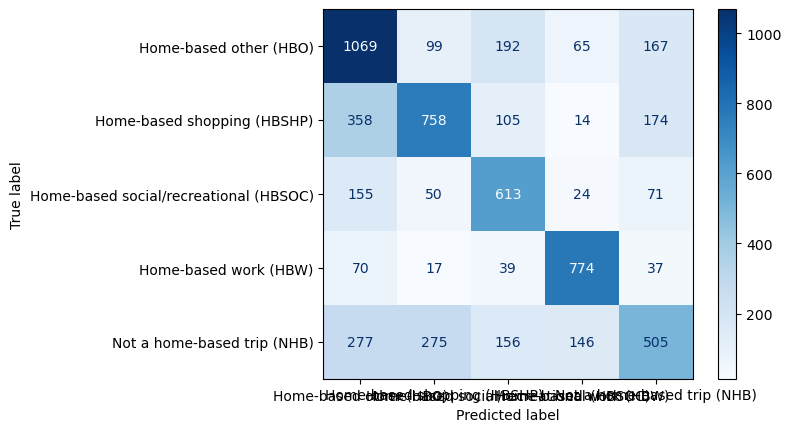

                                        precision    recall  f1-score   support

                Home-based other (HBO)       0.55      0.67      0.61      1592
           Home-based shopping (HBSHP)       0.63      0.54      0.58      1409
Home-based social/recreational (HBSOC)       0.55      0.67      0.61       913
                 Home-based work (HBW)       0.76      0.83      0.79       937
           Not a home-based trip (NHB)       0.53      0.37      0.44      1359

                              accuracy                           0.60      6210
                             macro avg       0.61      0.62      0.60      6210
                          weighted avg       0.60      0.60      0.59      6210



In [82]:
# Create confusion matrix
cm = confusion_matrix(y_test, NN_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=vis.cat.categories)
disp.plot(cmap='Blues')
plt.show()

# Create classification report
print(classification_report(y_test, NN_preds, target_names=vis.cat.categories))

In [83]:
param_grid = {
    'C': [0.1, 1, 10],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear', 'saga']
}

lr_model = LogisticRegression()

grid_search = GridSearchCV(lr_model, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(x_train, y_train)

best_params = grid_search.best_params_
best_model = grid_search.best_estimator_
logit_pred = best_model.predict(x_test)
y_pred = best_model.predict(x_test)
Logit_accuracy = accuracy_score(y_test, y_pred)

/Users/mariongeary/anaconda3/envs/dsan6600/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/mariongeary/anaconda3/envs/dsan6600/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/mariongeary/anaconda3/envs/dsan6600/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/mariongeary/anaconda3/envs/dsan6600/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/mariongeary/anaconda3/envs/dsan6600/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_

In [84]:
print(best_params)
print(best_model)

{'C': 10, 'penalty': 'l1', 'solver': 'liblinear'}
LogisticRegression(C=10, penalty='l1', solver='liblinear')


In [85]:
# Save sklearn model
import pickle

pickle.dump(best_model, open("../models/logit_model.pkl", "wb"))

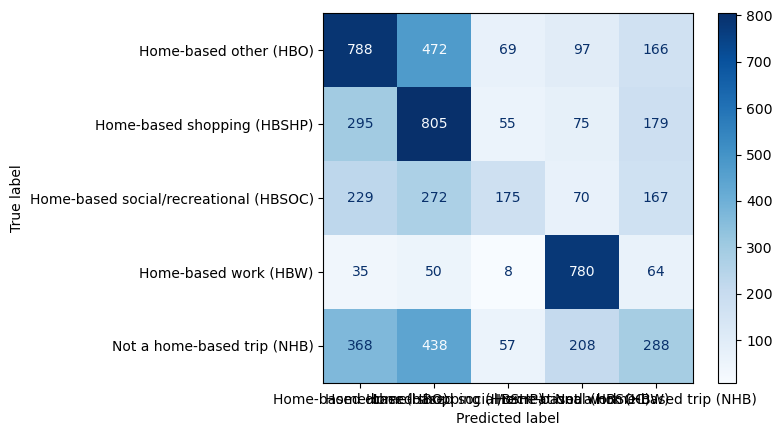

                                        precision    recall  f1-score   support

                Home-based other (HBO)       0.46      0.49      0.48      1592
           Home-based shopping (HBSHP)       0.40      0.57      0.47      1409
Home-based social/recreational (HBSOC)       0.48      0.19      0.27       913
                 Home-based work (HBW)       0.63      0.83      0.72       937
           Not a home-based trip (NHB)       0.33      0.21      0.26      1359

                              accuracy                           0.46      6210
                             macro avg       0.46      0.46      0.44      6210
                          weighted avg       0.45      0.46      0.43      6210



In [86]:
# Create confusion matrix
cm = confusion_matrix(y_test, logit_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=vis.cat.categories)
disp.plot(cmap='Blues')
plt.show()

# Create classification report
print(classification_report(y_test, logit_pred, target_names=vis.cat.categories))

In [87]:
param_grid = {
    'max_depth': [3, 6, 9],
    'learning_rate': [0.1, 0.01, 0.001],
    'n_estimators': [100, 200, 300],
    'gamma': [0, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
}

model1 = xgb.XGBClassifier()
grid_search = RandomizedSearchCV(estimator=model1, param_distributions=param_grid, n_iter=20, scoring='accuracy', cv=3)
grid_search.fit(x_train, y_train)
best_params = grid_search.best_params_

xgboost_model = xgb.XGBClassifier(**best_params)
xgboost_model.fit(x_train, y_train)

agboost_pred = xgboost_model.predict(x_test)
xgboost_accuracy = accuracy_score(y_test, agboost_pred)

In [88]:
# Save sklearn model
pickle.dump(xgboost_model, open("../models/xgboost_model.pkl", "wb"))

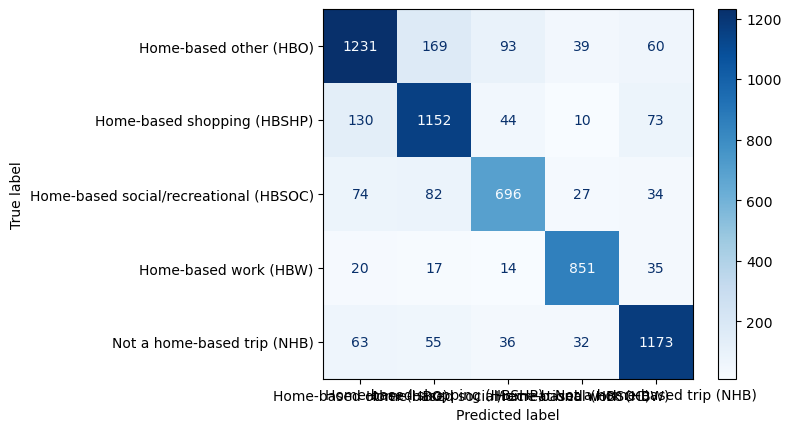

                                        precision    recall  f1-score   support

                Home-based other (HBO)       0.81      0.77      0.79      1592
           Home-based shopping (HBSHP)       0.78      0.82      0.80      1409
Home-based social/recreational (HBSOC)       0.79      0.76      0.78       913
                 Home-based work (HBW)       0.89      0.91      0.90       937
           Not a home-based trip (NHB)       0.85      0.86      0.86      1359

                              accuracy                           0.82      6210
                             macro avg       0.82      0.82      0.82      6210
                          weighted avg       0.82      0.82      0.82      6210



In [89]:
# Create confusion matrix
cm = confusion_matrix(y_test, agboost_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=vis.cat.categories)
disp.plot(cmap='Blues')
plt.show()

# Create classification report
print(classification_report(y_test, agboost_pred, target_names=vis.cat.categories))

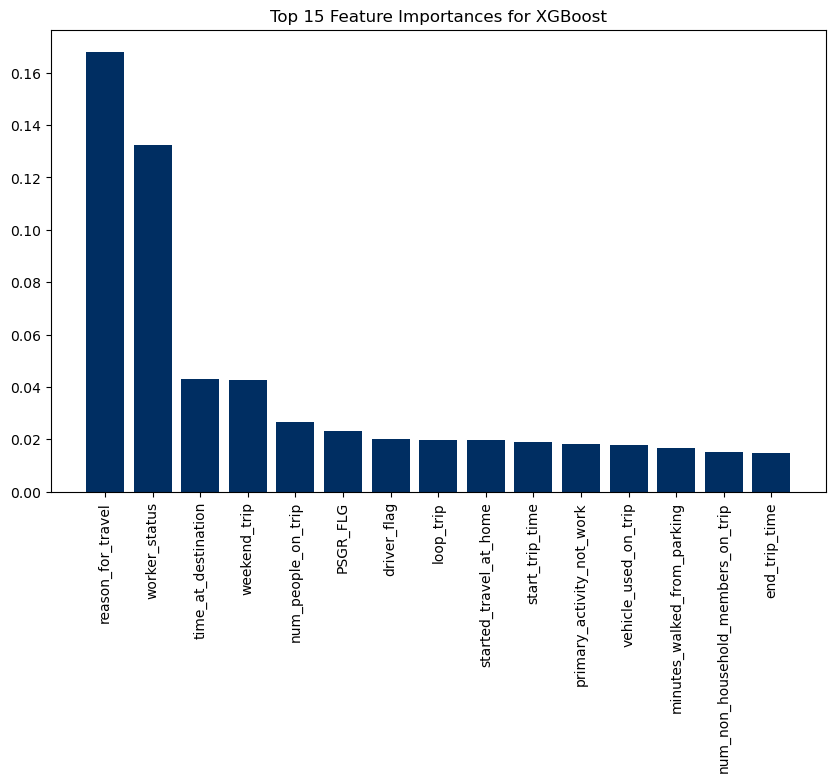

In [110]:
# Plot feature importance
x_train_df = pd.DataFrame(x_train, columns=trip.drop('trip_purpose', axis=1).columns)

n = 15
importances = xgboost_model.feature_importances_
indices = np.argsort(importances)[::-1]
plt.figure(figsize=(10, 6))
plt.title(f'Top {n} Feature Importances for XGBoost')
plt.bar(range(n), importances[indices[:n]], color = "#002e62")
plt.xticks(range(n), x_train_df.columns[indices[:n]], rotation=90)
plt.show()

In [104]:
best_c = 10
best_kernel = "poly"
svc = SVC(C=best_c, kernel=best_kernel, probability=True)
svc.fit(x_train, y_train)

SVM_pred = svc.predict(x_test)
svm_accuracy = accuracy_score(y_test, SVM_pred)

In [105]:
# Save sklearn model
pickle.dump(svc, open("../models/svm_model.pkl", "wb"))

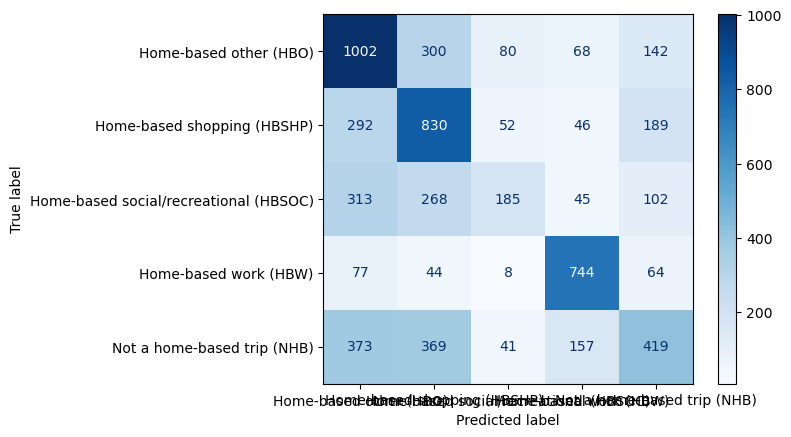

                                        precision    recall  f1-score   support

                Home-based other (HBO)       0.49      0.63      0.55      1592
           Home-based shopping (HBSHP)       0.46      0.59      0.52      1409
Home-based social/recreational (HBSOC)       0.51      0.20      0.29       913
                 Home-based work (HBW)       0.70      0.79      0.75       937
           Not a home-based trip (NHB)       0.46      0.31      0.37      1359

                              accuracy                           0.51      6210
                             macro avg       0.52      0.50      0.49      6210
                          weighted avg       0.51      0.51      0.49      6210



In [106]:
# Create confusion matrix
cm = confusion_matrix(y_test, SVM_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=vis.cat.categories)
disp.plot(cmap='Blues')
plt.show()

# Create classification report
print(classification_report(y_test, SVM_pred, target_names=vis.cat.categories))

## Random Forest

In [93]:
from sklearn.ensemble import RandomForestClassifier

param_grid = {
    'n_estimators': [50, 100],
    'max_depth': list(range(1,15)),
    'min_samples_split': list(range(2,6))
}
rf = RandomForestClassifier(n_jobs=-1)
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(x_train, y_train)
best_params = grid_search.best_params_

rf_model = RandomForestClassifier(**best_params)
rf_model.fit(x_train, y_train)

rf_pred = rf_model.predict(x_test)
rf_accuracy = accuracy_score(y_test, rf_pred)

In [94]:
# Save sklearn model
pickle.dump(rf_model, open("../models/rf_model.pkl", "wb"))

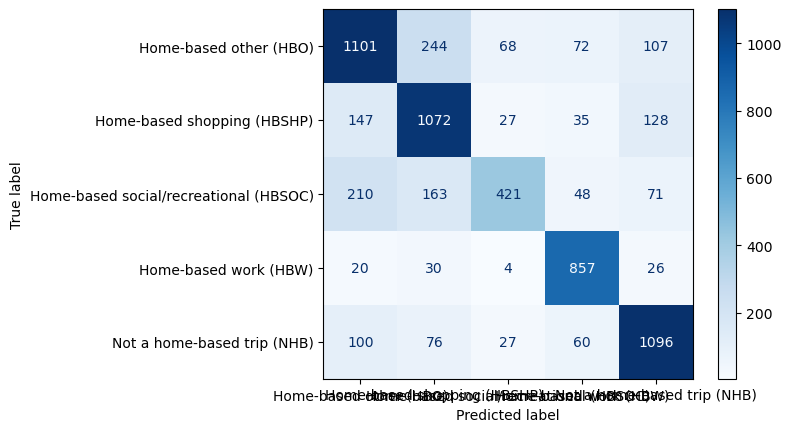

                                        precision    recall  f1-score   support

                Home-based other (HBO)       0.70      0.69      0.69      1592
           Home-based shopping (HBSHP)       0.68      0.76      0.72      1409
Home-based social/recreational (HBSOC)       0.77      0.46      0.58       913
                 Home-based work (HBW)       0.80      0.91      0.85       937
           Not a home-based trip (NHB)       0.77      0.81      0.79      1359

                              accuracy                           0.73      6210
                             macro avg       0.74      0.73      0.73      6210
                          weighted avg       0.73      0.73      0.73      6210



In [95]:
# Create confusion matrix
cm = confusion_matrix(y_test, rf_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=vis.cat.categories)
disp.plot(cmap='Blues')
plt.show()

# Create classification report
print(classification_report(y_test, rf_pred, target_names=vis.cat.categories))

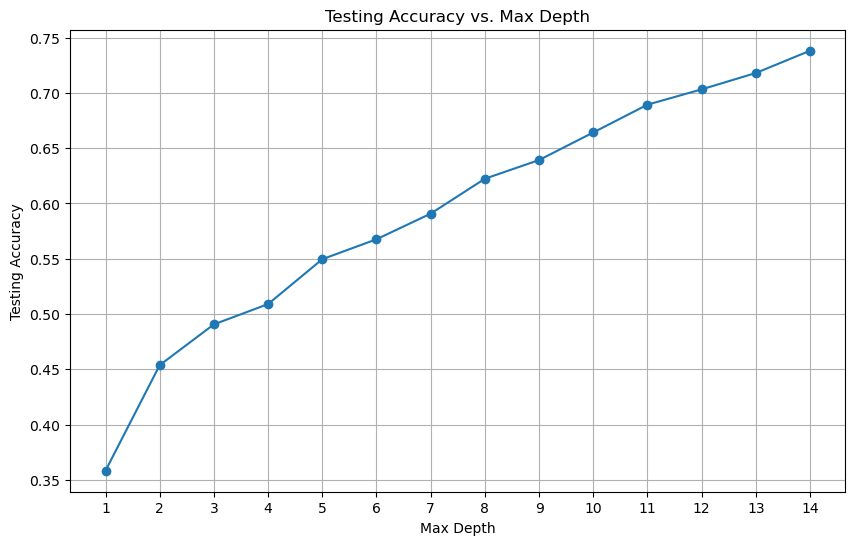

In [96]:
import matplotlib.pyplot as plt

# Initialize lists to store max depth and testing accuracies
max_depth_values = []
test_accuracies = []

# Iterate over different max depth values
for max_depth in range(1, 15):
    # Initialize the random forest classifier with the current max depth
    rf = RandomForestClassifier(max_depth=max_depth, min_samples_split=3, n_estimators=100)
    
    # Fit the model
    rf.fit(x_train, y_train)
    
    # Evaluate the model on the test set
    test_accuracy = rf.score(x_test, y_test)
    
    # Append max depth and corresponding test accuracy to the lists
    max_depth_values.append(max_depth)
    test_accuracies.append(test_accuracy)

# Plotting the results
plt.figure(figsize=(10, 6))
plt.plot(max_depth_values, test_accuracies, marker='o')
plt.title('Testing Accuracy vs. Max Depth')
plt.xlabel('Max Depth')
plt.ylabel('Testing Accuracy')
plt.xticks(max_depth_values)
plt.grid(True)
plt.show()

In [142]:
# Save max depth and testing accuracies to a DataFrame
max_depth_accuracies = pd.DataFrame({
    'Max Depth': max_depth_values,
    'Testing Accuracy': test_accuracies
})

# Save the DataFrame to a CSV file
max_depth_accuracies.to_csv('../models/max_depth_accuracies.csv', index=False)

In [143]:
max_depth_accuracies

,Max Depth,Testing Accuracy
0,1,0.358293
1,2,0.453784
2,3,0.490660
3,4,0.509018
4,5,0.549597
5,6,0.567633
6,7,0.590821
7,8,0.622383
8,9,0.639291
9,10,0.664251


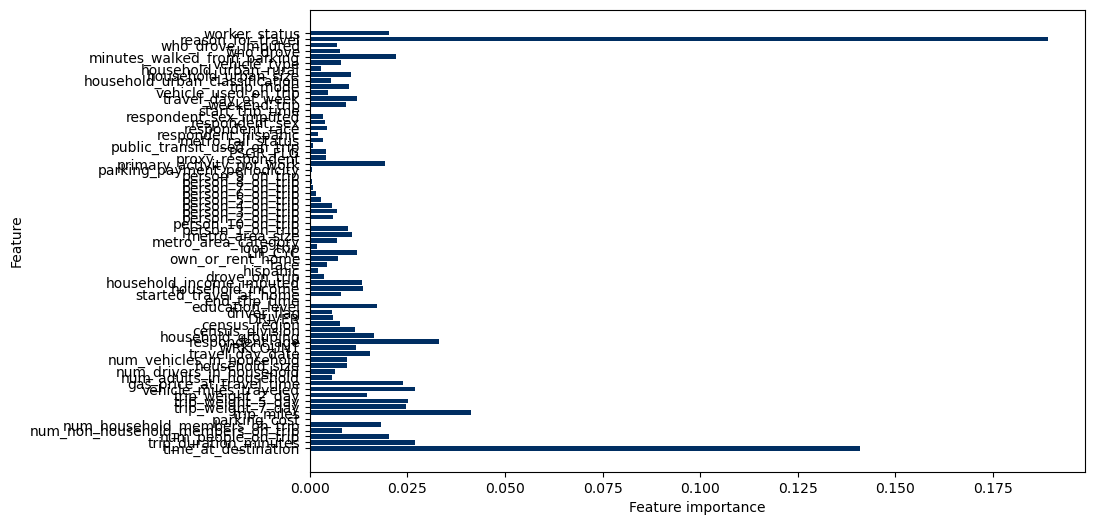

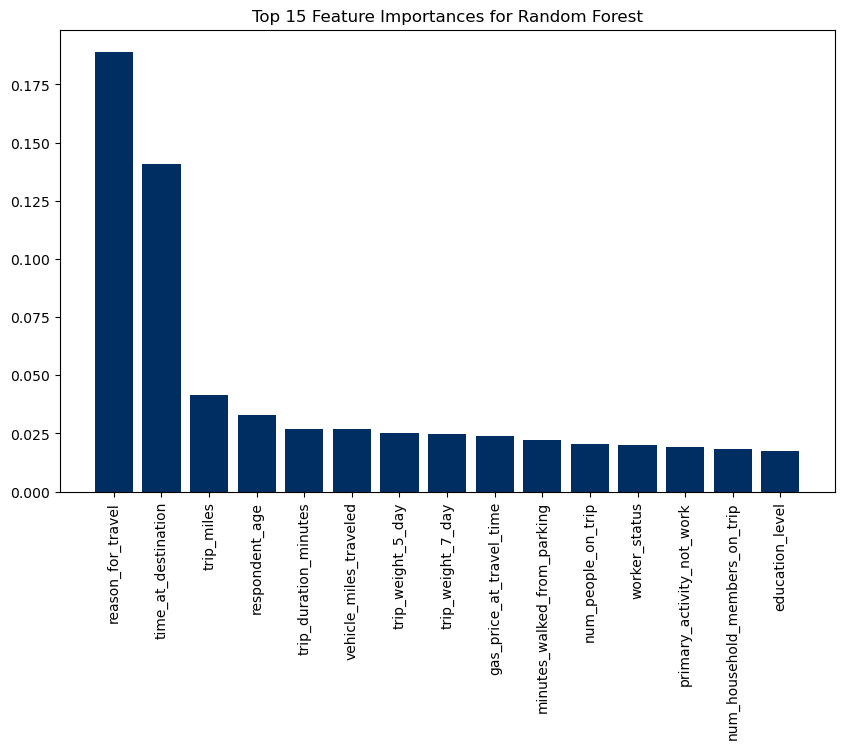

In [97]:
### Feature Importance plot
def plot_feature_importances(model, feature_names):
    n_features = len(feature_names)
    plt.figure(figsize=(10, 6))  
    plt.barh(range(n_features), model.feature_importances_, align='center', color = "#002e62")
    plt.yticks(range(n_features), feature_names)
    plt.xlabel("Feature importance")
    plt.ylabel("Feature")
    plt.show()

# convert x_train to a DataFrame
x_train_df = pd.DataFrame(x_train, columns=trip.drop('trip_purpose', axis=1).columns)


plot_feature_importances(rf, x_train_df.columns)

# Plot the top n most important features
n = 15
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]
plt.figure(figsize=(10, 6))
plt.title(f'Top {n} Feature Importances for Random Forest')
plt.bar(range(n), importances[indices[:n]], color = "#002e62")
plt.xticks(range(n), x_train_df.columns[indices[:n]], rotation=90)
plt.show()

195/195 [==============================] - 1s 3ms/step


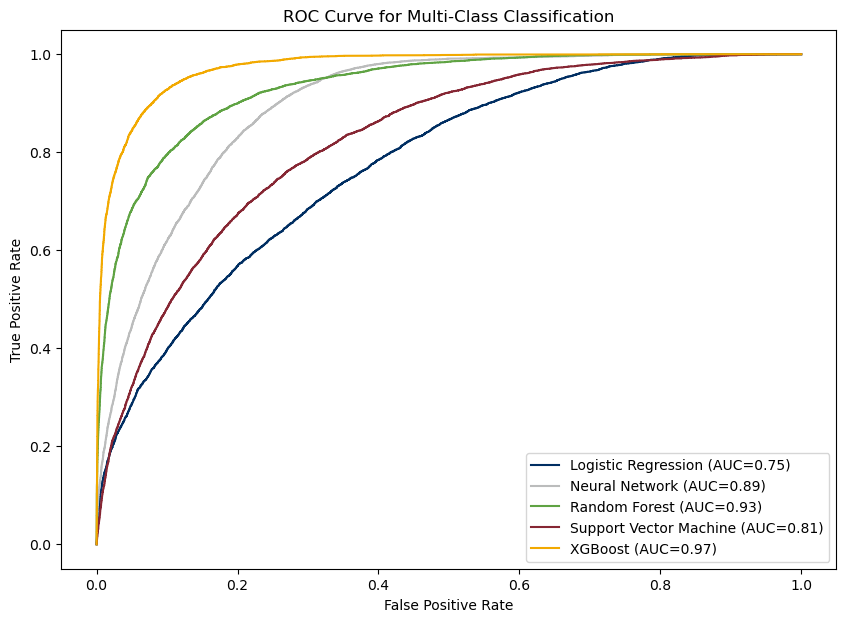

In [176]:
from sklearn.preprocessing import label_binarize

models = [best_model, model, rf_model, svc, xgboost_model]
colors = ['#002e62', '#BBBCBC', '#5FA343', '#862633', '#F2A900']
names = ["Logistic Regression", "Neural Network", "Random Forest", "Support Vector Machine", "XGBoost"]
fig, ax = plt.subplots(figsize=(10, 7))
for mod in models:
    y_test_binary = label_binarize(y_test, classes=np.unique(y_test))
    if hasattr(mod, 'predict_proba'):
        y_pred_proba = mod.predict_proba(x_test)
    elif hasattr(mod, 'decision_function'):
        y_pred_proba = mod.decision_function(x_test)
    else:
        y_pred_proba = model.predict(x_test)
    fpr, tpr, _ = roc_curve(y_test_binary.ravel(), y_pred_proba.ravel())
    roc_auc = roc_auc_score(y_test_binary, y_pred_proba)
    ax.plot(fpr, tpr, label=f"{names[models.index(mod)]} (AUC={roc_auc:.2f})", color=colors[models.index(mod)])

ax.set_title('ROC Curve for Multi-Class Classification')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.legend()
plt.show()

In [99]:
print(f"NN Accuracy: {NN_accuracy}")
print(f"Logistic regression accuracy: {Logit_accuracy}")
print(f"Xgboost accuracy: {xgboost_accuracy}")
print(f"SVM accuracy: {svm_accuracy}")
print(f"Random Forest accuracy: {rf_accuracy}")

NN Accuracy: 0.5988727807998657
Logistic regression accuracy: 0.456682769726248
Xgboost accuracy: 0.8217391304347826
SVM accuracy: 0.5120772946859904
Random Forest accuracy: 0.7322061191626409


In [100]:
# Save all model predictions and actual values
model_preds = {
    "NN": NN_preds,
    "Logistic Regression": logit_pred,
    "Xgboost": agboost_pred,
    "SVM": SVM_pred,
    "RF": rf_pred,
    "Actual": y_test
}

model_preds_df = pd.DataFrame(model_preds)

model_preds_df.to_csv("../models/model_predictions.csv", index=False)

In [132]:
# Save model probabilities as long format. Each column is the probability of a class
nn_probs = {
    f"NN_{i}": predictions[:, i] for i in range(5)
}

nn_probs_df = pd.DataFrame(nn_probs)

nn_probs_df.to_csv("../models/nn_probs.csv", index=False)

logit_probs = best_model.predict_proba(x_test)
logit_probs_df = pd.DataFrame(logit_probs, columns=[f"Logit_{i}" for i in range(5)])
logit_probs_df.to_csv("../models/logit_probs.csv", index=False)

xgboost_probs = xgboost_model.predict_proba(x_test)
xgboost_probs_df = pd.DataFrame(xgboost_probs, columns=[f"Xgboost_{i}" for i in range(5)])
xgboost_probs_df.to_csv("../models/xgboost_probs.csv", index=False)

svm_probs = svc.predict_proba(x_test)
svm_probs_df = pd.DataFrame(svm_probs, columns=[f"SVM_{i}" for i in range(5)])
svm_probs_df.to_csv("../models/svm_probs.csv", index=False)

rf_probs = rf_model.predict_proba(x_test)
rf_probs_df = pd.DataFrame(rf_probs, columns=[f"RF_{i}" for i in range(5)])
rf_probs_df.to_csv("../models/rf_probs.csv", index=False)

# Combine all into one dataframe
all_probs = pd.concat([nn_probs_df, logit_probs_df, xgboost_probs_df, svm_probs_df, rf_probs_df, model_preds_df], axis=1)
all_probs.to_csv("../models/all_probs.csv", index=False)

                         Feature  importance_sum          Model  Importance
140            reason_for_travel        0.363550  Random Forest    0.195500
69             reason_for_travel        0.363550        XGBoost    0.168050
71           time_at_destination        0.176276  Random Forest    0.133127
70                 worker_status        0.153574        XGBoost    0.132309
0            time_at_destination        0.176276        XGBoost    0.043149
58                  weekend_trip        0.052382        XGBoost    0.042627
77                    trip_miles        0.050611  Random Forest    0.042394
89                respondent_age        0.045550  Random Forest    0.034675
72         trip_duration_minutes        0.035034  Random Forest    0.026672
2             num_people_on_trip        0.048133        XGBoost    0.026469
73            num_people_on_trip        0.048133  Random Forest    0.021664
137  minutes_walked_from_parking        0.037942  Random Forest    0.021395
141         

/Users/mariongeary/anaconda3/envs/dsan6600/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/mariongeary/anaconda3/envs/dsan6600/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/mariongeary/anaconda3/envs/dsan6600/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/mariongeary/anaconda3/envs/dsan6600/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecat

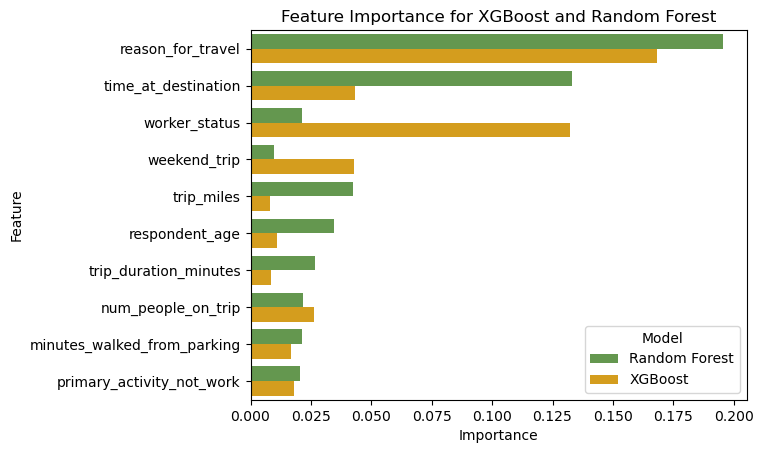

In [172]:
# Plot XGBoost vs Random Forest feature importance
n = 15
importances_xgboost = xgboost_model.feature_importances_
importances_rf = rf_model.feature_importances_

# Combine the feature importances into a single DataFrame
importances_df = pd.DataFrame({
    'Feature': x_train_df.columns,
    'XGBoost': importances_xgboost,
    'Random Forest': importances_rf
})

# Sort the DataFrame by feature importance
importances_df['importance_sum'] = importances_df['XGBoost'] + importances_df['Random Forest']
importances_df = importances_df.melt(id_vars=['Feature', 'importance_sum'], var_name='Model', value_name='Importance')

import seaborn as sns

n = 10
# Plot the feature importances with bar chart where bars are next to each other
plt.title(f'Feature Importance for XGBoost and Random Forest')
top_n_features = importances_df.sort_values(by='importance_sum', ascending=False).drop_duplicates(subset='Feature').head(n)
top_n_importances = importances_df[importances_df['Feature'].isin(top_n_features['Feature'])]
top_n_importances = top_n_importances.sort_values(by='importance_sum', ascending=False)
top_n_importances = top_n_importances.sort_values(by=['Model'], ascending=True).sort_values(by=['Importance'], ascending=False)
print(top_n_importances)
sns.barplot(x='Importance', y='Feature', hue='Model', data=top_n_importances)
# Set color palette with hex color codes
sns.set_palette(sns.color_palette(["#5FA343", "#F2A900"]))
plt.show()